In [1]:
import numpy as np
import matplotlib.pyplot as plt
import struct, os

In [2]:
from utils.extract_utils import *
from utils.latticeeasy import *
from utils.gradient_utils import gradient_discrete

In [3]:
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
rc('text', usetex=True)
rc('image', cmap='gist_heat_r')
rc('axes', **{'titlesize': 11})

plt.rcParams['axes.axisbelow'] = True

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load data

In [4]:
output_dir = "/media/yangelaxue/TRANSFER/Colliding_Oscillons/alpha_beta-0.25_80_351.512634/osc4_128/stationary_128"
data = LATTICEEASY(output_dir)
data.__dict__

{'output_dir': '/media/yangelaxue/TRANSFER/Colliding_Oscillons/alpha_beta-0.25_80_351.512634/osc4_128/stationary_128',
 'alpha': 0.25,
 'beta': 80.0,
 'phi_0': 0.080613,
 'dt_pr': 0.001,
 'domain_width_pr': array([0.299627, 0.299627, 0.299627]),
 'domain_dimensions': (128, 128, 128),
 't': array([ 0.500997,  1.001991,  1.503014,  2.004037,  2.505001,  3.005965,
         3.506928,  4.007892,  4.508855,  5.009819,  5.510783,  6.011746,
         6.51271 ,  7.013674,  7.514637,  8.01561 ,  8.516812,  9.018015,
         9.519217, 10.02042 , 10.521623, 11.022825, 11.524028, 12.02523 ,
        12.526433, 13.027636, 13.528838, 14.030041, 14.531243, 15.032446,
        15.533648, 16.034817, 16.535542, 17.036266, 17.536991, 18.037716,
        18.538441, 19.039165, 19.53989 , 20.040615, 20.54134 , 21.042065,
        21.542789, 22.043514, 22.544239, 23.044964, 23.545689, 24.046413,
        24.547138, 25.047863, 25.548588, 26.049313, 26.550037, 27.050762,
        27.551487, 28.052212, 28.552937, 29.

In [5]:
timeslice = 0

a, ap = data.a[timeslice], data.ap[timeslice]

dt_pr = data.dt_pr
domain_width_pr = data.domain_width_pr
domain_dimensions = data.domain_dimensions
domain_width_pr, domain_dimensions

(array([0.299627, 0.299627, 0.299627]), (128, 128, 128))

In [6]:
n_points = np.product(domain_dimensions)

grid_file = "stationary.img"
with open(os.path.join(output_dir,grid_file),'rb') as grid:
    
    grid_content = grid.read()
    
    phi = struct.unpack("f" * n_points, grid_content[16:16+4*n_points])
    phip = struct.unpack("f" * n_points, grid_content[16+4*n_points:])
    
phi = np.array(phi).reshape(domain_dimensions)
phip = np.array(phip).reshape(domain_dimensions)

phi = phi - dt_pr/2 * phip

In [7]:
Edens = get_Edens_pr(
    phi, phip, a, ap, data.alpha, data.beta, data.phi_0, dxdydz_pr=domain_width_pr/domain_dimensions
    )

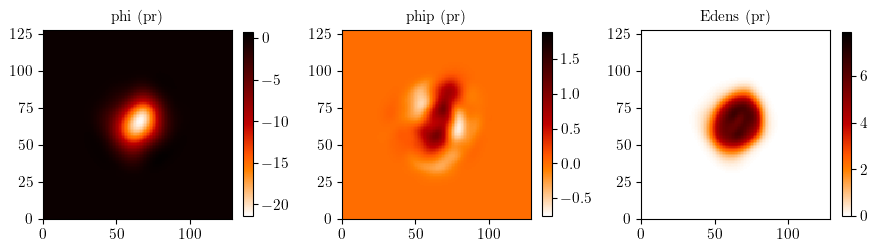

In [8]:
cross = 64

fig, axes = plt.subplots(1,3,figsize=(9,4),tight_layout=True)

for ax in axes:
    ax.set_aspect('equal')

mesh = axes[0].pcolormesh(phi[:,cross],
              vmin=phi.min(), vmax=phi.max(),
              )
axes[0].set_title("phi (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[1].pcolormesh(phip[:,cross],
              vmin=phip.min(), vmax=phip.max(),
              )
axes[1].set_title("phip (pr)")
fig.colorbar(mesh,shrink=.5)

mesh = axes[2].pcolormesh(Edens[:,cross],
              vmin=Edens.min(), vmax=Edens.max(),
              )
axes[2].set_title("Edens (pr)")
fig.colorbar(mesh,shrink=.5)

plt.show()

# Interpolate

In [9]:
shape_i = (128,128,128)
# shape_i = (256,256,256)
# shape_i = data.domain_dimensions

if shape_i==data.domain_dimensions:
    print("skip interpolate")
    phi_i, phip_i, Edens_i = phi, phip, Edens
else:
    phi_i, phip_i, Edens_i = interpolate(shape_i, phi, phip, Edens)
    
print(phi_i.shape)

skip interpolate
(128, 128, 128)


# Shift oscillon to center

In [10]:
if 0:
    center = tuple(np.round(np.array([(Edens_i*x).sum() for x in np.indices(shape_i)])/Edens_i.sum()).astype(int))

    phi_sh, phip_sh, Edens_sh = shift_volume(center, phi_i, phip_i, Edens_i)
    
    cross = shape_i[0]//2

    fig, axes = plt.subplots(1,2,figsize=(6,4),tight_layout=True)

    for ax in axes:
        ax.set_aspect('equal')

    mesh = axes[0].pcolormesh(phi_sh[:,cross],
                  vmin=phi_i.min(), vmax=phi_i.max(),
                  )
    axes[0].set_title("phi (pr)")
    fig.colorbar(mesh,shrink=.5)

    mesh = axes[1].pcolormesh(phip_sh[:,cross],
                  vmin=phip_i.min(), vmax=phip_i.max(),
                  )
    axes[1].set_title("phip (pr)")
    fig.colorbar(mesh,shrink=.5)
else:
    phi_sh, phip_sh, Edens_sh = phi_i, phip_i, Edens_i

# Boost

In [11]:
c_pr = 1/a**(data.rescale_s+1) # Speed limit in code units
c_pr

0.0037783440049333774

In [12]:
"""
View momentum before applying boost.
"""

momenta_pr = get_momenta_pr(phi_sh, phip_sh, a, ap, data.alpha, data.beta, data.phi_0, domain_width_pr/shape_i)
field_speed_pr = get_field_speed_pr(momenta_pr, Edens_sh, a, data.alpha)

field_speed_pr/c_pr, momenta_pr.sum(axis=(1,2,3))

(array([ 5.55194231e-07,  1.11816551e-06, -3.74845616e-07]),
 array([ 24.8047554 ,  49.95697073, -16.74720899]))

In [13]:
# boost = np.array([0.042, -0.002625, 0.00573]) * c_pr # 128 res
boost = np.array([0.042, -0.002625, 0.00573]) * c_pr # 256 res

grad = gradient_discrete(phi_sh, domain_width_pr/shape_i, stencil=5)
phip_sh_boost = phip_sh - np.sum([boost_x*grad_x for boost_x,grad_x in zip(boost,grad)],axis=0)

Edens_boost = get_Edens_pr(
    phi_sh, phip_sh_boost, a, ap, data.alpha, data.beta, data.phi_0, dxdydz_pr=domain_width_pr/shape_i
    )

momenta_pr_boost = get_momenta_pr(phi_sh, phip_sh_boost, a, ap, data.alpha, data.beta, data.phi_0, domain_width_pr/shape_i)
field_speed_pr_boost = get_field_speed_pr(momenta_pr_boost, Edens_boost, a, data.alpha)
field_speed_pr_boost/c_pr, momenta_pr_boost.sum(axis=(1,2,3))

(array([1.00845810e-02, 2.06030831e-06, 1.32487876e-06]),
 array([4.50650494e+05, 9.20691654e+01, 5.92049653e+01]))

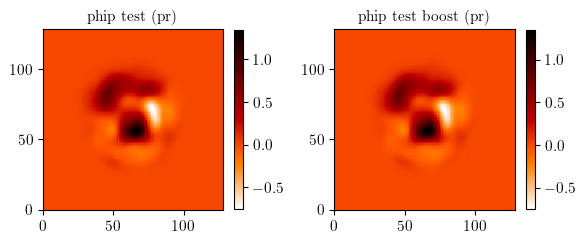

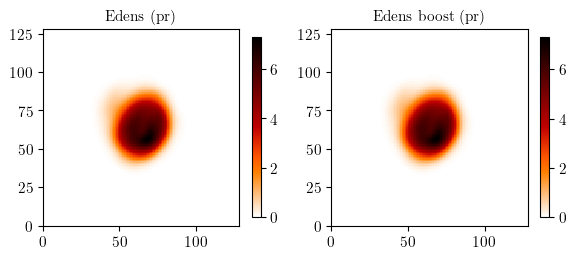

In [14]:
cross = shape_i[0]//2

fig, axes = plt.subplots(1,2,figsize=(6,2.9),tight_layout=True)

im = axes[0].pcolormesh(phip_sh[cross])
axes[0].set_title("phip test (pr)")
fig.colorbar(im,shrink=.7)

im = axes[1].pcolormesh(phip_sh_boost[cross])
axes[1].set_title("phip test boost (pr)")
fig.colorbar(im,shrink=.7)

for ax in axes:
    ax.set_aspect('equal')

plt.show()

fig, axes = plt.subplots(1,2,figsize=(6,2.9),tight_layout=True)

im = axes[0].pcolormesh(Edens_sh[cross])
axes[0].set_title("Edens (pr)")
fig.colorbar(im,shrink=.7)

im = axes[1].pcolormesh(Edens_boost[cross])
axes[1].set_title("Edens boost (pr)")
fig.colorbar(im,shrink=.7)

for ax in axes:
    ax.set_aspect('equal')

plt.show()

# Interpolate (again)

In [16]:
shape_i_2 = (128,128,128)
# shape_i_2 = (256,256,256)
# shape_i = data.domain_dimensions

if shape_i_2==shape_i:
    print("skip interpolate")
    phi_2, phip_2 = phi_sh, phip_sh_boost
else:
    phi_2, phip_2 = interpolate(shape_i_2, phi_sh, phip_sh_boost)
    Edens_2 = get_Edens_pr(
        phi_2, phip_2, a, ap, data.alpha, data.beta, data.phi_0, dxdydz_pr=domain_width_pr/shape_i_2
    )
    
    momenta_2 = get_momenta_pr(phi_2, phip_2, a, ap, data.alpha, data.beta, data.phi_0, domain_width_pr/shape_i_2)
    field_speed_2 = get_field_speed_pr(momenta_2, Edens_2, a, data.alpha)
    print(field_speed_2/c_pr)
    print(momenta_2.sum(axis=(1,2,3)))

skip interpolate


# Save data as grid.img

In [17]:
# dt_pr = data.dt_pr
dt_pr = 0.001

print(dt_pr)

phi_2_adv = phi_2 + dt_pr/2*phip_2

0.001


In [18]:
shape_i_2, domain_width_pr, dt_pr, data.phi_0, dt_pr/(domain_width_pr/shape_i_2)

((128, 128, 128),
 array([0.299627, 0.299627, 0.299627]),
 0.001,
 0.080613,
 array([0.42719782, 0.42719782, 0.42719782]))

In [20]:
n_points = np.product(shape_i_2)

fname_o = f"boost.img"
datname_o = f"boost.dat"
fdir = f"boost_0.01c_{shape_i_2[0]}"
# fname_o = f"highres_boost.img"
# datname_o = f"highres_boost.dat"
# fdir = f"highres_boost"
# fname_o = f"stationary.img"
# datname_o = f"stationary.dat"
# fdir = f"stationary_{shape_i[0]}"

# fname_o = f"cont.img"
# datname_o = f"cont.dat"
# fdir = f"./"
# fname_o = f"{fname}_noboost.img"
# datname_o = f"{fname}_noboost.dat"

if not os.path.exists(os.path.join(output_dir, fdir)):
    os.makedirs(os.path.join(output_dir, fdir))

with open(os.path.join(output_dir, fdir, datname_o), 'w') as dat:
    dat.write(f"N = {phi_2_adv.shape}\n")
    dat.write(f"L_pr = {domain_width_pr}\n")
    dat.write(f"dt_pr = {dt_pr}\n")
    dat.write(f"f0 = {data.phi_0}\n")
    dat.write(f"\n")
    
    dat.write(f"Boost given in x, y, z direction in code units is\n")
    dat.write(f"{boost/c_pr} x c_pr = {boost}\n")
    dat.write("Final average speed compared to c is\n")
    dat.write(f"{field_speed_pr_boost/c_pr} x c_pr = {field_speed_pr_boost} \n")
    
#     dat.write("\n")
#     dat.write("This was boosted first and then interpolated.\n")
    
#     if "boost" in fdir:
#         dat.write(f"Or .01c_pr in the x direction.\n")
    
#     if fdir=="highres_boost":
#         dat.write("\n")
#         dat.write(f"High resolution timesteps begins at t={data.t[timeslice]}\n")
    
    dat.write("\n")
    dat.write(f"{output_dir = }")

with open(os.path.join(output_dir, fdir, fname_o),'wb') as f_o:
    
    f_o.write(struct.pack('<i',-1))
#     f_o.write(struct.pack('<f',data.t[timeslice]))
    f_o.write(struct.pack('<f',0))
    f_o.write(struct.pack('<f',data.a[timeslice]))
    f_o.write(struct.pack('<f',data.ap[timeslice]))
    
    f_o.write(struct.pack('<'+'f'*n_points,*phi_2_adv.flatten()))
    f_o.write(struct.pack('<'+'f'*n_points,*phip_2.flatten()))